### Airbnb user segmentation
#### airbnb客户聚类分群

- Airbnb爱彼迎是全球民宿短租公寓预定平台,全球700万特色民宿、短租、酒店、公寓、客栈覆盖191个国家和地区短租民宿房源。它拥有广泛的用户出行场景数据，通过这些数据，锁定潜在的目标客群并制定相应的营销策略是Airbnb业务发展的基石。

- 要分析的问题：应用聚类方法来分析airbnb用户群体的核心特征。

- 数据表的主要字段：  
    id：用户id  
    date_account_created：用户创建日期  
    date_first_booking：第一次订房日期  
    gender：性别  
    age：年龄  
    married：已婚  
    children：小孩数量  
    android：曾自爱安卓app中预定  
    mowed：曾在手机移动网页预定  
    wed：曾在电脑网页版预定  
    ios：曾在ios app预定  
    language_en：使用英文语言  
    language_zh：使用中文语言  
    country_us：目的地是美国  
    country_eu：目的地是欧洲国家  


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

airbnb = pd.read_csv('airbnb_cluster.csv')
airbnb.head()

,age,date_account_created,date_first_booking,gender,Language_EN,Language_ZH,Country_US,Country_EUR,android,moweb,web,ios,Married,Children
0,56,9/28/2010,8/2/2010,F,1,0,1,0,1,0,1,0,1,1
1,42,12/5/2011,9/8/2012,F,1,0,0,0,0,1,1,0,0,1
2,41,9/14/2010,2/18/2010,U,1,0,1,0,1,0,1,0,0,2
3,46,1/2/2010,1/5/2010,F,1,0,1,0,1,0,1,0,0,2
4,47,1/3/2010,1/13/2010,F,1,0,1,0,1,0,1,0,1,3


In [61]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67936 entries, 0 to 67935
Data columns (total 14 columns):
age                     67936 non-null int64
date_account_created    67936 non-null object
date_first_booking      67936 non-null object
gender                  67936 non-null object
Language_EN             67936 non-null int64
Language_ZH             67936 non-null int64
Country_US              67936 non-null int64
Country_EUR             67936 non-null int64
android                 67936 non-null int64
moweb                   67936 non-null int64
web                     67936 non-null int64
ios                     67936 non-null int64
Married                 67936 non-null int64
Children                67936 non-null int64
dtypes: int64(11), object(3)
memory usage: 7.3+ MB


#### Data preprocess
1. check value range  
first, take a look of overall numeric columns, finding age has some outliers. considering we may only target person from 18 to 80, we will constraint age in this range

In [62]:
# the max value of age is not reasonable, we will take a closer look 
print(airbnb.describe())

# value of age
print('number of age out of range:%d'%np.sum(airbnb['age']>80))

                age   Language_EN   Language_ZH    Country_US   Country_EUR  \
count  67936.000000  67936.000000  67936.000000  67936.000000  67936.000000   
mean      47.874249      0.974476      0.005947      0.713907      0.159091   
std      146.090906      0.157711      0.076886      0.451937      0.365764   
min        2.000000      0.000000      0.000000      0.000000      0.000000   
25%       28.000000      1.000000      0.000000      0.000000      0.000000   
50%       33.000000      1.000000      0.000000      1.000000      0.000000   
75%       42.000000      1.000000      0.000000      1.000000      0.000000   
max     2014.000000      1.000000      1.000000      1.000000      1.000000   

            android         moweb           web           ios       Married  \
count  67936.000000  67936.000000  67936.000000  67936.000000  67936.000000   
mean       0.658355      0.340423      0.895828      0.067534      0.790155   
std        0.474265      0.473855      0.305485    

(array([1125., 1288., 2974., 5083., 6617., 7018., 6967., 6113., 5052.,
        3918., 3042., 2515., 2131., 1999., 1490., 1976., 1112.,  972.,
         956.,  826.,  708.,  618.,  550.,  453.,  360.,  198.,  186.,
         103.,   61.,   62.]),
 array([18.        , 20.06666667, 22.13333333, 24.2       , 26.26666667,
        28.33333333, 30.4       , 32.46666667, 34.53333333, 36.6       ,
        38.66666667, 40.73333333, 42.8       , 44.86666667, 46.93333333,
        49.        , 51.06666667, 53.13333333, 55.2       , 57.26666667,
        59.33333333, 61.4       , 63.46666667, 65.53333333, 67.6       ,
        69.66666667, 71.73333333, 73.8       , 75.86666667, 77.93333333,
        80.        ]),
 <a list of 30 Patch objects>)

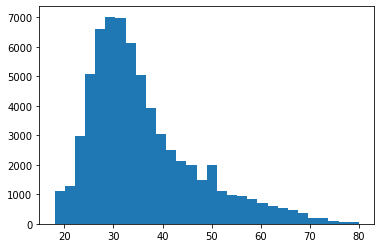

In [63]:
airbnb = airbnb[(airbnb['age']>=18)&(airbnb['age']<=80)].copy()
plt.hist(airbnb['age'], bins=30)

2. Process datetime  
date_account_created and date_first_booking

In [64]:
# convert object to datetime
airbnb['date_account_created'] = pd.to_datetime(airbnb['date_account_created'])
airbnb['date_first_booking'] = pd.to_datetime(airbnb['date_first_booking'])

airbnb['date_first_booking'].describe()

count                   66473
unique                   1944
top       2014-05-22 00:00:00
freq                      190
first     2010-01-04 00:00:00
last      2015-06-28 00:00:00
Name: date_first_booking, dtype: object

In [65]:
# time difference
airbnb['datediff'] = (airbnb['date_first_booking']-airbnb['date_account_created'])
airbnb['datediff'] = airbnb['datediff'].apply(lambda x:x.days)

airbnb['datediff'].describe()

count    66473.000000
mean        50.695034
std         92.591874
min       -349.000000
25%          1.000000
50%          4.000000
75%         45.000000
max        365.000000
Name: datediff, dtype: float64

3. Prepare dataset for clustering

In [66]:
airbnb = pd.get_dummies(airbnb)
airbnb = airbnb.drop(['date_account_created','date_first_booking','gender_U'],axis=1)
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66473 entries, 0 to 67935
Data columns (total 14 columns):
age            66473 non-null int64
Language_EN    66473 non-null int64
Language_ZH    66473 non-null int64
Country_US     66473 non-null int64
Country_EUR    66473 non-null int64
android        66473 non-null int64
moweb          66473 non-null int64
web            66473 non-null int64
ios            66473 non-null int64
Married        66473 non-null int64
Children       66473 non-null int64
datediff       66473 non-null int64
gender_F       66473 non-null uint8
gender_M       66473 non-null uint8
dtypes: int64(12), uint8(2)
memory usage: 6.7 MB


#### Feature selection - correlation matrix
According to correlation matrix plot below, we can identify some features have high (negative) correlation with some other features, which, in the end, will give those variables more weights when calculate distances. So, I will remove one of those variable in each pair with high correlation and it turns out that Country_US, Andorid, web and gender_F will be removed. 

Text(0.5, 1, 'Correlation Matrix')

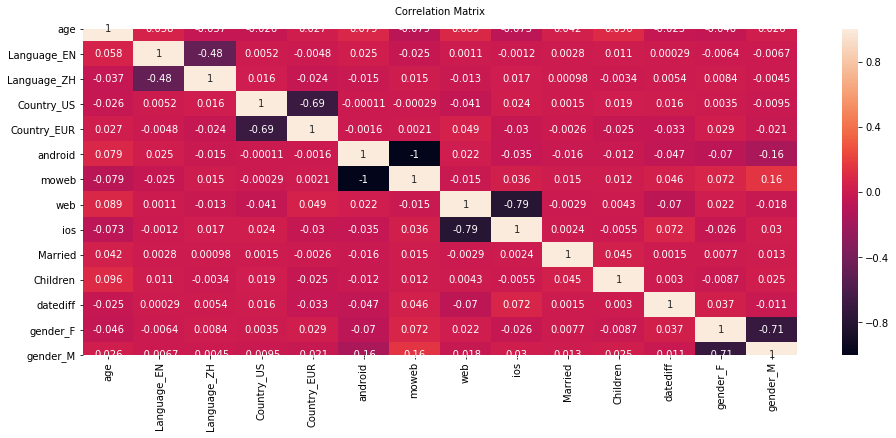

In [67]:
import seaborn as sns

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(airbnb.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':10}, pad=14)

In [68]:
# remove high-correlated features
airbnb = airbnb.drop(["Country_US", 'android', 'web','gender_F'],axis=1)
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66473 entries, 0 to 67935
Data columns (total 10 columns):
age            66473 non-null int64
Language_EN    66473 non-null int64
Language_ZH    66473 non-null int64
Country_EUR    66473 non-null int64
moweb          66473 non-null int64
ios            66473 non-null int64
Married        66473 non-null int64
Children       66473 non-null int64
datediff       66473 non-null int64
gender_M       66473 non-null uint8
dtypes: int64(9), uint8(1)
memory usage: 5.1 MB


#### Cluster modeling
Training a dataset with over 64k observations is such a time-consuming work, so in this practice, I only split it for once.  

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# data spliting - 60/20/20
train, test = train_test_split(airbnb, test_size=0.2, random_state=42) 
train, valid = train_test_split(train, test_size=0.25, random_state=42) 
# data scaling
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
valid_scaled = scaler.transform(valid)
test_scaled = scaler.transform(test)

# overview of data spliting
print('train set shape: (%d, %d)'%(train_scaled.shape[0],train_scaled.shape[1]))
print('valid set shape: (%d, %d)'%(valid_scaled.shape[0],valid_scaled.shape[1]))
print('test set shape: (%d, %d)'%(test_scaled.shape[0],test_scaled.shape[1]))
df = pd.DataFrame(train_scaled, columns=airbnb.columns)
df.head()

train set shape: (39883, 10)
valid set shape: (13295, 10)
test set shape: (13295, 10)


,age,Language_EN,Language_ZH,Country_EUR,moweb,ios,Married,Children,datediff,gender_M
0,-0.368243,0.161843,-0.076492,-0.434999,1.381451,-0.269041,0.514550,1.745014,-0.351263,1.258610
1,-0.642368,0.161843,-0.076492,-0.434999,-0.723876,-0.269041,0.514550,-0.638832,-0.372940,1.258610
2,-0.276868,0.161843,-0.076492,2.298858,-0.723876,-0.269041,0.514550,-0.638832,1.783919,-0.794527
3,2.098885,0.161843,-0.076492,-0.434999,-0.723876,-0.269041,0.514550,0.553091,-0.394616,-0.794527
4,0.728258,0.161843,-0.076492,-0.434999,1.381451,-0.269041,-1.943445,0.553091,2.260812,-0.794527


1. k-Means clustering


In [71]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.cluster import silhouette_score
from scipy.cluster.hierarchy import dendrogram, ward

s_score_train = []
s_score_valid = []
for k in range(2,11):
    algo = KMeans(n_clusters=k,random_state=10)
    clusters_train = algo.fit_predict(train_scaled)
    clusters_valid = algo.predict(valid_scaled)
    s_score_train.append(silhouette_score(train_scaled, clusters_train))
    s_score_valid.append(silhouette_score(valid_scaled, clusters_valid))

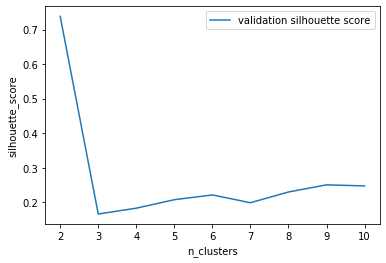

In [72]:
#plt.plot(range(2,11), s_score_train, label="train silhouette score")
plt.plot(range(2,11), s_score_valid, label="validation silhouette score")
plt.ylabel("silhouette_score")
plt.xlabel("n_clusters")
plt.legend()

In [73]:
# cluster using test data
algo = KMeans(n_clusters=2,random_state=10)
clusters_train = algo.fit_predict(train_scaled)
clusters_valid = algo.predict(valid_scaled)
clusters_test = algo.predict(test_scaled)
print(silhouette_score(test_scaled, clusters_test))

0.7377414962153087


2. Agglomerative clustering

In [80]:
s_score_train = []
s_score_valid = []
for k in range(2,11):
    algo = AgglomerativeClustering(n_clusters=k)
    clusters_train = algo.fit_predict(train_scaled)
    clusters_valid = algo.fit_predict(valid_scaled)
    s_score_train.append(silhouette_score(train_scaled, clusters_train))
    s_score_valid.append(silhouette_score(valid_scaled, clusters_valid))


KeyboardInterrupt: 

In [ ]:
#plt.plot(range(2,11), s_score_train, label="train silhouette score")
plt.plot(range(2,11), s_score_valid, label="validation silhouette score")
plt.ylabel("silhouette_score")
plt.xlabel("n_clusters")
plt.legend()

#### Find characteristic of each group
Plot number of clusters against silhouette score and we can see that k-Means get its highest score when we have 2 clusters. Added a 'cluster' column to the original dataset

In [74]:
train['cluster'] = clusters_train
valid['cluster'] = clusters_valid
test['cluster'] = clusters_test
airbnb_clustered = pd.concat([train, valid, test])
airbnb_clustered.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,Language_EN,Language_ZH,Country_EUR,moweb,ios,Married,Children,datediff,gender_M,cluster
50698,32,1,0,0,1,0,1,3,18,1,0
61433,29,1,0,0,0,0,1,1,16,1,0
8286,33,1,0,1,0,0,1,1,215,0,0
21401,59,1,0,0,0,0,1,2,14,0,0
15091,44,1,0,0,1,0,0,2,259,0,0


In [75]:
np.sum(airbnb_clustered['cluster'])

401

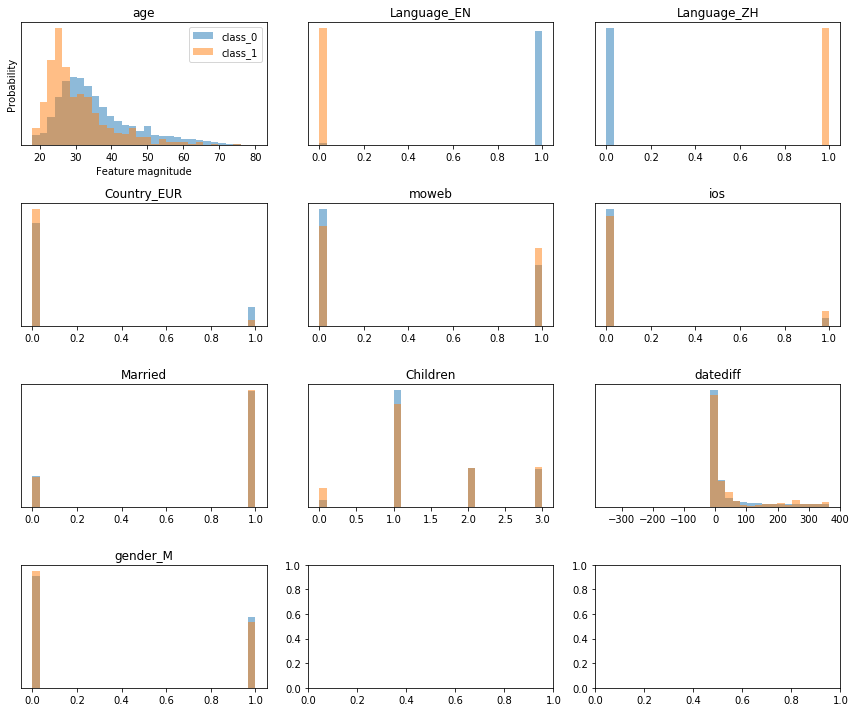

In [76]:
fig, axes = plt.subplots(4, 3, figsize=(12, 10)) 
class_0 = airbnb_clustered[airbnb_clustered['cluster'] == 0] 
class_1 = airbnb_clustered[airbnb_clustered['cluster'] == 1]
ax = axes.ravel()

for i in range(10):
    _, bins = np.histogram(airbnb_clustered.iloc[:, i], bins=30) 
    ax[i].hist(class_0.iloc[:, i], bins=bins, alpha=.5,density=True) 
    ax[i].hist(class_1.iloc[:, i], bins=bins, alpha=.5,density=True) 
    ax[i].set_title(airbnb_clustered.columns[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude") 
ax[0].set_ylabel("Probability") 
ax[0].legend(["class_0", "class_1"], loc="best") 
fig.tight_layout()